Can I generate uncertainties for the Phoenix models using Monte Carlo? Is it too computationally expensive?

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
import prepare_phoenix_svo as pp
from timeit import default_timer as timer

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
params = Table.read('stellar_parameters.csv')

In [3]:
params

Target,RAJ2000,DEJ2000,Jmag,J_e,Hmag,H_e,Kmag,K_e,Rmag,R_e,spt,L_bol,L_bol_e,Mass,Mass_e,Radius,Radius_e,Teff,Teff_e,parallax,distance,P_rot_d
str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64
GJ 1132,153.716027,-47.156796,9.245,0.026,8.666,0.031,8.322,0.027,13.098,0.11,M3.5,1.67e+31,5e+29,0.194,0.005,0.215,0.009,3196,72,83.07,12.03804021,126.59
GJ 676A,262.546646,-51.637012,6.711,0.02,6.082,0.024,5.825,0.029,8.675,0.012,M0,3.404e+32,8.3e+30,0.631,0.017,0.62,0.03,4014,94,63.07,15.85539876,41.2
GJ 15A,4.594036,44.022842,5.252,0.264,4.476,0.2,4.018,0.02,7.9,0.012,M1,8.61e+31,7e+29,0.393,0.009,0.385,0.002,3601,12,280.74,3.562014676,-1.0
GJ 649,254.536873,25.74423,6.448,0.021,5.865,0.02,5.624,0.016,8.685,0.012,M1,1.674e+32,1.7e+30,0.524,0.012,0.531,0.012,3621,41,96.38,10.3755966,-1.0
GJ 163,62.315307,-53.373737,7.948,0.026,7.428,0.04,7.135,0.021,10.734,0.012,M3.5,8.28e+31,2.4e+30,0.405,0.01,0.409,0.017,3460,76,66.59,15.01726986,61.0
GJ 849,332.417906,-4.640765,6.51,0.024,5.899,0.044,5.594,0.017,9.279,0.012,M3.5,1.105e+32,1e+30,0.465,0.011,0.464,0.018,3492,70,113.25,8.830022075,39.2
GJ 674,262.166316,-46.89513,5.711,0.019,5.154,0.033,4.855,0.018,8.337,0.012,M2.5,6.03e+31,1.4e+30,0.353,0.008,0.361,0.012,3404,59,220.24,4.540501271,32.9
GJ 699,269.452044,4.694597,5.244,0.02,4.834,0.034,4.524,0.02,8.298,0.012,M4,1.3e+31,2e+29,0.161,0.004,0.187,0.001,3223,17,548.31,1.823785815,130.4
L 980-5,215.313034,-1.122204,8.948,0.03,8.391,0.031,8.093,0.026,13.02,0.15,M3.5,2.49e+31,8e+29,0.232,0.006,0.25,0.01,3278,74,74.66,13.39405304,92.23


In [4]:
G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
for m, r, t in zip(params['Mass'], params['Radius'], params['Teff']):
    g = G*(m*M)/(r*R)**2
    g =  g.to(u.cm/u.s**2)
    print(t,np.log10(g.value))
    #print(logg)

3196 5.060992437402149
4014 4.65331360755076
3601 4.861538718661559
3621 4.707209872123922
3460 4.822076034503119
3492 4.772484619083325
3404 4.87082792887964
3223 5.101210290261985
3278 5.007675594849958
3119 5.113824503742217
3248 5.083980902336978
2619 5.292907918630075


In [12]:
from numpy.random import default_rng
rng = default_rng()

[{'Teff': 3100, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3100, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
[{'Teff': 3100, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3100, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
[{'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3300, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
[{'Teff': 3100, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3100, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.0, 'FeH': 0.0, 'aM': 0.0}, {'Teff': 3200, 'logg': 5.5, 'FeH': 0.0, 'aM': 0.0}]
47.894856373997754


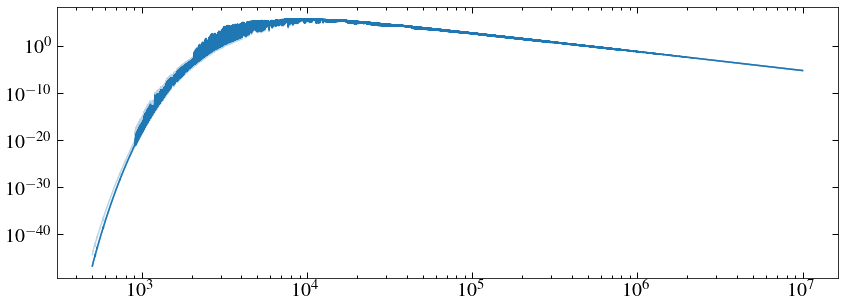

In [26]:
###### pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=False, plot=False)
#star_params = {'Teff': 2628, 'logg': 5.21, 'FeH': 0.00, 'aM': 0, 'radius':1.16*u.R_jup, 'distance':12.43*u.pc}
G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
save_path = 'interpolated_models/'
# repo = '/media/david/5tb_storage1/muscles/btsettl_models/'
# repo = '/media/david/1tb_storage1/emergency_data/mega_muscles/data-vacuum/'
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'
for row in params[0:1]:
    star = row['Target']
    star = star.replace(' ', '')
    if star == 'Trappist-1':
        star = '2MASS-J23062928-0502285'
#     if star != 'Trappist-1':# and star == 'GJ 15A':



    g = (G*(row['Mass']*M)/(row['Radius']*R)**2).to(u.cm/u.s**2)
    star_params = {'Teff': row['Teff'], 'logg': np.log10(g.value), 'FeH': 0.00, 'aM': 0, 'Radius':row['Radius']*u.R_sun, 'Distance':row['distance']*u.pc}
    meanw, meanf = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=False, plot=False)
    plt.plot(meanw, meanf, c='C0', zorder=10)
    # print(row['Mass'], row['Mass_e'])
    n = 3
    mdist = rng.normal(row['Mass'], row['Mass_e'], n)
    tdist = rng.normal(row['Teff'], row['Teff_e'], n)
    rdist = rng.normal(row['Radius'], row['Radius_e'], n)
    start = timer()
    
    for i in range(n):
        mi, ti, ri = mdist[i], tdist[i], rdist[i]
        g = (G*(mi*M)/(ri*R)**2).to(u.cm/u.s**2)
        star_params = {'Teff': ti, 'logg': np.log10(g.value), 'FeH': 0.00, 'aM': 0, 'Radius':ri*u.R_sun, 'Distance':row['distance']*u.pc}
        wi, fi = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=False, plot=False)
        plt.plot(wi, fi, c='C0', alpha=0.3, zorder=-1)
        
    end = timer()
    print(end - start)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    
    
    # pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=False, plot=True)

In [28]:
((48/3)*10000)*u.s.to(u.hr)

44.44444444444444

So 44 hours for one star, let alone the storage/memory requirements. May need a different approach. Find out which one has the biggest effect on the SED?

In [ ]:
    # 145.6500 -9.02815D+01 -8.25000D+01   3  20    618.6719 1000 128    891.3070    7 128      0.0000    0 129  1000  6.186719D+02 -1.659000D+00  1.240001D-04     7  8.913070D+02 -1.536133D+00  8.758349D-02   1   1  6.34802D+07  6.01154D+07
     #    145.7000-8.97833D+01-7.98488D+01   3  19    618.6719 1000 128    892.6923    7 128      0.0000    0 129  1000 6.186719D+02-1.659000D+00 1.240001D-04     7 8.926923D+02-1.389459D+00 8.758349D-02   1   1 2.10674D+07 2.07329D+07